In [1]:
import pylab as pl
import numpy as np
import scipy as sp
import scipy.optimize as spo
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
import pydot
import graphviz

In [2]:
# Prepare the Training and Validation Data

batch_x_train = []
batch_y_train = []

df_1 = pd.read_csv('np_lin_100.csv') 

for index, rows in df_1.iterrows():
    batch_y_train.append(0)
    list_1 = rows
    batch_x_train.append(list_1)
    
df_2 = pd.read_csv('np_circ_100.csv')            

for index, rows in df_2.iterrows():
    batch_y_train.append(1)
    list_2 = rows
    batch_x_train.append(list_2)

batch_x_train = np.asarray(batch_x_train)
batch_y_train = tf.keras.utils.to_categorical(batch_y_train, num_classes=2)
batch_y_test = batch_y_train

batch_x_test = []

df_3 = pd.read_csv('np_t_lin_100.csv')

for index, rows in df_3.iterrows():
    list_3 = rows
    batch_x_test.append(list_3)
    
df_4 = pd.read_csv('np_t_circ_100.csv')
for index, rows in df_4.iterrows():
    list_4 = rows
    batch_x_test.append(list_4)
    
batch_x_test = np.asarray(batch_x_test)

#data standardization
batch_x_train = batch_x_train.reshape((batch_x_train.shape[0], batch_x_train.shape[1], 1)) 
batch_x_test = batch_x_test.reshape((batch_x_test.shape[0], batch_x_test.shape[1], 1))

num_classes = len(np.unique(batch_y_train))
idx = np.random.permutation(len(batch_x_train))
batch_x_train = batch_x_train[idx]
batch_y_train = batch_y_train[idx]

tf.keras.backend.clear_session()

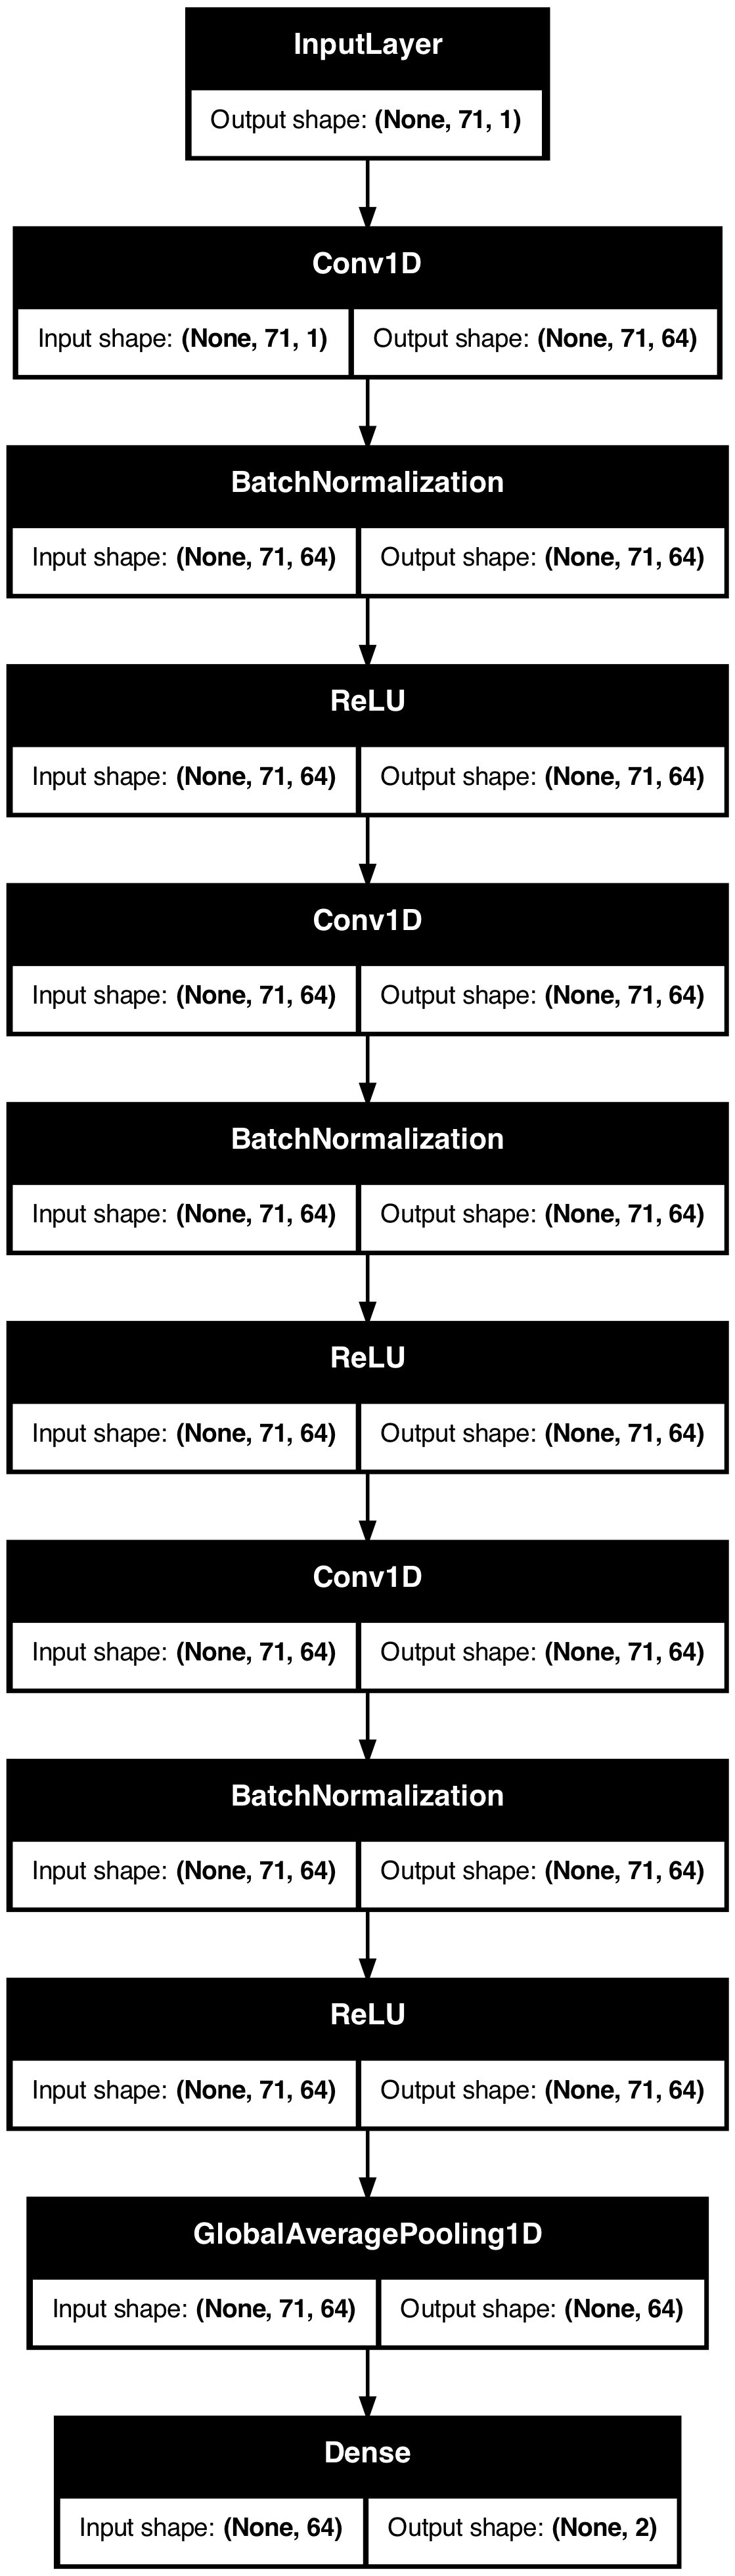

In [3]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=2, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=2, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=2, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=batch_x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [4]:
epochs = 200
batch_size = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=25, min_lr=0.001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    batch_x_train,
    batch_y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.6307 - loss: 0.6228 - val_categorical_accuracy: 0.5200 - val_loss: 0.6745 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6910 - loss: 0.5497 - val_categorical_accuracy: 0.5900 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7236 - loss: 0.5282 - val_categorical_accuracy: 0.5700 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7211 - loss: 0.5197 - val_categorical_accuracy: 0.7000 - val_loss: 0.6384 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7236 - loss: 0.5214 - val_categorical_accuracy: 0.7600 - val_loss: 0.6149 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7236 - loss: 0.5338 - val_categorical_accuracy:

In [5]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(batch_x_test, batch_y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6888 - loss: 0.5577  
Test accuracy 0.6887550354003906
Test loss 0.5576847195625305


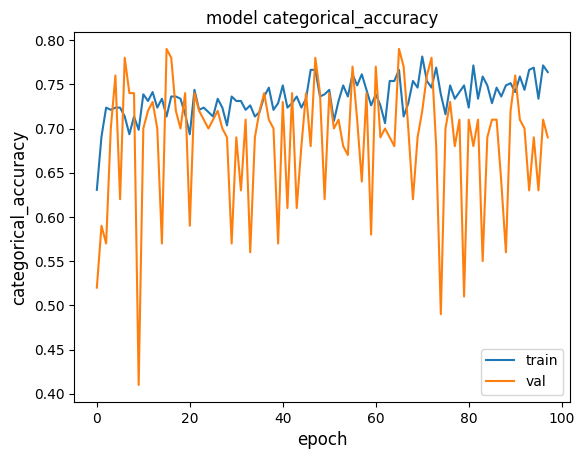

In [6]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()